# TP OpenMP - October 2022
## Part 1 : Pi
### Compilation

In [44]:
!g++ -o tp_openmp_part_1_pi_impl_critical part1/tp_openmp_part_1_pi_impl_critical.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_reduce part1/tp_openmp_part_1_pi_impl_reduce.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_atomic part1/tp_openmp_part_1_pi_impl_atomic.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_1_pi_impl_n_reduction part1/tp_openmp_part_1_pi_n_reduction.cpp -fopenmp -O3 -march=native


### Performance evaluation

In [45]:
import os
import subprocess
import pandas as pd

try:
    os.remove("stats.csv")
except OSError:
    pass

import pandas as pd

df = pd.DataFrame(columns=['version','nthread','num_steps','runtime'])
df.to_csv("stats_part1.csv", index=False)

num_steps = [10000, 1000000, 10000000, 100000000]
nb_threads = [1, 2, 4, 8]
repeats = range(0,10)

for nsteps in num_steps:
    for nthread in nb_threads:
        for repeat in repeats:
            args = ("./tp_openmp_part_1_pi_impl_critical", "-T", str(nthread), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            
            args = ("./tp_openmp_part_1_pi_impl_reduce", "-T", str(nthread), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            args = ("./tp_openmp_part_1_pi_impl_atomic", "-T", str(nthread), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()


            args = ("./tp_openmp_part_1_pi_impl_n_reduction", "-T", str(nthread), "-N", str(nsteps))
            popen = subprocess.Popen(args, stdout=subprocess.PIPE)
            popen.wait()

            



### Performance analysis
#### Weak scaling

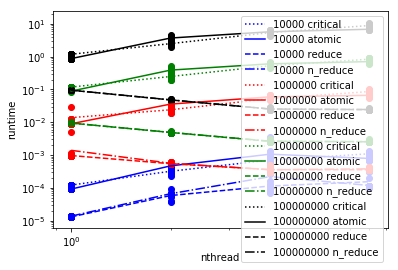

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('stats_part1.csv',header=0,names=['version','nthread','num_steps','runtime'],dtype={
                     'version': str,
                     'nthread': int,
                     'num_steps' : int,
                     'runtime' : float
                 })

color_num_steps = {10000 : "blue", 1000000 : "red", 10000000 : "green", 100000000 : "black"}

for num_steps in df['num_steps'].drop_duplicates():
    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "critical"]
    
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="dotted",color=color_num_steps[num_steps], label=f'{num_steps} critical')
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)


    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "atomic"]
    
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="solid",color=color_num_steps[num_steps], label=f'{num_steps} atomic')
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)

    df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == "reduce")]
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    #std_stats = df_plot.groupby(['num_steps','version','nthread']).std().reset_index()
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="dashed",color=color_num_steps[num_steps], label= f'{num_steps} reduce')
    plt.yscale('log')
    plt.xscale('log')
    #plt.errorbar(df_plot['nthread'], df_plot['runtime'], 0.00005, linestyle='None', marker='^')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)


    df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == "n_reduce")]
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    #std_stats = df_plot.groupby(['num_steps','version','nthread']).std().reset_index()
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="dashdot",color=color_num_steps[num_steps], label=f'{num_steps} n_reduce')
    plt.yscale('log')
    plt.xscale('log')
    #plt.errorbar(df_plot['nthread'], df_plot['runtime'], 0.00005, linestyle='None', marker='^')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)
    
plt.xlabel('nthread')
plt.ylabel('runtime')

plt.legend()
plt.show()

#### Strong Scaling

### Discussion

## Part 2 : Matrix-Vector operation
### Compilation

In [24]:
!g++ -o tp_openmp_part_2_1_vector part2/tp_openmp_part_2_1_vector.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_2_2_vector part2/tp_openmp_part_2_2_vector.cpp -fopenmp -O3 -march=native
!g++ -o tp_openmp_part_2_3_vector part2/tp_openmp_part_2_3_vector.cpp -fopenmp -O3 -march=native

### Performance evaluation

#### Sequential Code

In [25]:
import os
import subprocess
import pandas as pd

try:
    os.remove("stats_part2.csv")
except OSError:
    pass


df = pd.DataFrame(columns=['name','N','M','nrepeat','runtime'])
df.to_csv("stats_part2.csv", index=False)

N = [2,4,8,10,12,14,16]

for n in N:
    #Sequential
    args = ("./tp_openmp_part_2_1_vector", "-N", str(n), "-M", str(n-1))
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()

    #Pragma omp with reduce
    args = ("./tp_openmp_part_2_2_vector", "-N", str(n), "-M", str(n-1))
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()

    #PRame omp with reduce and simd
    args = ("./tp_openmp_part_2_3_vector", "-N", str(n), "-M", str(n-1))
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()





### Performance analysis

name
2_1    AxesSubplot(0.125,0.125;0.775x0.755)
2_2    AxesSubplot(0.125,0.125;0.775x0.755)
2_3    AxesSubplot(0.125,0.125;0.775x0.755)
Name: runtime, dtype: object

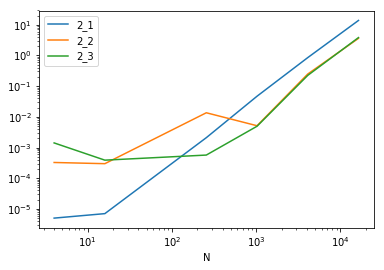

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('stats_part2.csv',header=0,names=['name','N','M','nrepeats','runtime'],dtype={
                     'name' : str,
                     'N': int,
                     'M': int,
                     'nrepeats' : int,
                     'runtime' : float
                 })


df_group = df.groupby('name')
plt.yscale('log')
plt.xscale('log')
df.set_index('N', inplace=True)
df_group['runtime'].plot(legend=True)

#### Parralelelezirzezed code

In [ ]:
import os
import subprocess
import pandas as pd

try:
    os.remove("stats_part2.csv")
except OSError:
    pass


df = pd.DataFrame(columns=['N','M','nrepeat','runtime'])
df.to_csv("stats_part2.csv", index=False)

N = [2,4,8,10,12,14,16]

for n in N:
    args = ("./tp_openmp_part_2_vector", "-N", str(N), "-M", str(M))
    popen = subprocess.Popen(args, stdout=subprocess.PIPE)
    popen.wait()





### Performance analysis


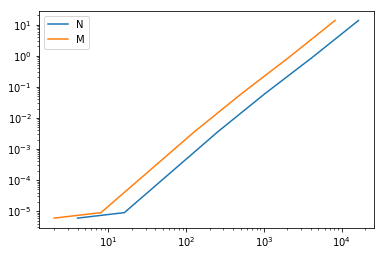

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('stats_part2.csv',header=0,names=['N','M','nrepeats','runtime'],dtype={
                     'N': int,
                     'M': int,
                     'nrepeats' : int,
                     'runtime' : float
                 })

color_num_steps = {10000 : "blue", 1000000 : "red", 10000000 : "green", 100000000 : "black"}

plt.yscale('log')
plt.xscale('log')
plt.plot(df['N'], df['runtime'], label="N")


plt.plot(df['M'], df['runtime'], label="M")
plt.legend()

In [ ]:

for num_steps in df['num_steps'].drop_duplicates():
    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "critical"]
    
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="dotted",color=color_num_steps[num_steps], label=f'{num_steps} critical')
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)


    df_plot = df[(df['num_steps'] == int(num_steps))]
    df_plot = df_plot[df_plot['version'] == "atomic"]
    
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="solid",color=color_num_steps[num_steps], label=f'{num_steps} atomic')
    plt.yscale('log')
    plt.xscale('log')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)

    df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == "reduce")]
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    #std_stats = df_plot.groupby(['num_steps','version','nthread']).std().reset_index()
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="dashed",color=color_num_steps[num_steps], label= f'{num_steps} reduce')
    plt.yscale('log')
    plt.xscale('log')
    #plt.errorbar(df_plot['nthread'], df_plot['runtime'], 0.00005, linestyle='None', marker='^')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)


    df_plot = df[(df['num_steps'] == num_steps) & (df['version'] == "n_reduce")]
    mean_stats = df_plot.groupby(['num_steps','version','nthread']).mean().reset_index()
    #std_stats = df_plot.groupby(['num_steps','version','nthread']).std().reset_index()
    plt.plot(mean_stats['nthread'], mean_stats['runtime'],linestyle="dashdot",color=color_num_steps[num_steps], label=f'{num_steps} n_reduce')
    plt.yscale('log')
    plt.xscale('log')
    #plt.errorbar(df_plot['nthread'], df_plot['runtime'], 0.00005, linestyle='None', marker='^')
    plt.scatter(df_plot['nthread'], df_plot['runtime'],color=color_num_steps[num_steps], label=None)
    
plt.xlabel('nthread')
plt.ylabel('runtime')

plt.legend()
plt.show()